<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXECUTIVE SUMMARY

5- 10 sentences

- What is analysis about
- Whatfindings are very important


Analysis about public bike rentals in Chicago: understanding patterns, understanding how demand is driven abd by what, etc.

Main findings:
1. Bike rentals in Chicago are mainly used for XYZ. Although alternative uses like XYZ and XYZ are also important blah blah blah. Segmenting teh ue cases blah blah.

2. Bike rental demand is mainly driven by 1. 2. 3.
Understanding XYZ XYZ

3. The city of Chicago needs to keep the demand factors in mind to optimize the service is peaks XYZ and be able to do amntenance in low pekas. Lw peaks are driven by XYZ XYZ

Some qualitative info:
"Service alert: Due to the upcoming subzero temperatures forecasted, some ebikes and scooters may be unavailable for use. Classic bikes availability shouldn’t be impacted." Currently on the website

ANSWER TO FIRST QUESTION

**Based on your analysis, are the majority of rentals for leisure, exercise, or commuting to work? Provide data-driven evidence for your claim, as well as at least one source from external research.**

* Quick intro on how succesful (A Tale of Two Divvys: The Bicycle Sharing System of Chicago — Bergman (2024, Sustainability).)
* Average rental demand is higher on working days (≈725 rentals) than on non-working days (≈676 rentals), suggesting that commuting-related usage contributes meaningfully to overall bike demand. Slightly higher usage of bikes on working days than during the weekends. But specially on specific hours during working days: peak hours.




In [49]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

fatal: destination path 'business_analysis_structured_data' already exists and is not an empty directory.
Current working directory changed to: /content/business_analysis_structured_data


In [50]:
# Importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
import sklearn.linear_model                          # faster linear modeling
import numpy as np                                   # mathematical essentials\
import warnings

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

In [51]:
# Better dataframe readability:
# Making all column names lowercase and replace spaces with underscores
bikerentals.columns = (
                        bikerentals.columns
                        .str.lower()            #lowercase
                        .str.replace(" ", "_")  #replace spaces
                        )

# Making holiday a boolean
bikerentals["holiday"] = (
                          bikerentals["holiday"]
                          .map({"Yes": 1, "No": 0}))

In [52]:
# Creating new variable to identify working days
# Working day = during the week and not a holiday
# Will be used as a proxy to identify commuters
bikerentals["is_working_day"] = (
    (bikerentals["day_of_week"] != "Saturday") &
    (bikerentals["day_of_week"] != "Sunday") &
    (bikerentals["holiday"] == 0)
).astype(int)

In [53]:
# # Setting up figures style and size consistent for all notebook
sns.set_theme(style="ticks", # white background and small tick marks
              palette="colorblind") # better color for all

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.titlepad": 12,  # space between title and plot
    "axes.labelpad": 8, # space between axis labels and axes
    "axes.titlesize": 13,
    "axes.labelsize": 11
})

# Better visibility for mean visualization in histograms
mp = {
    "markerfacecolor": "black",
    "markeredgecolor": "black",
    "markersize": 6
}

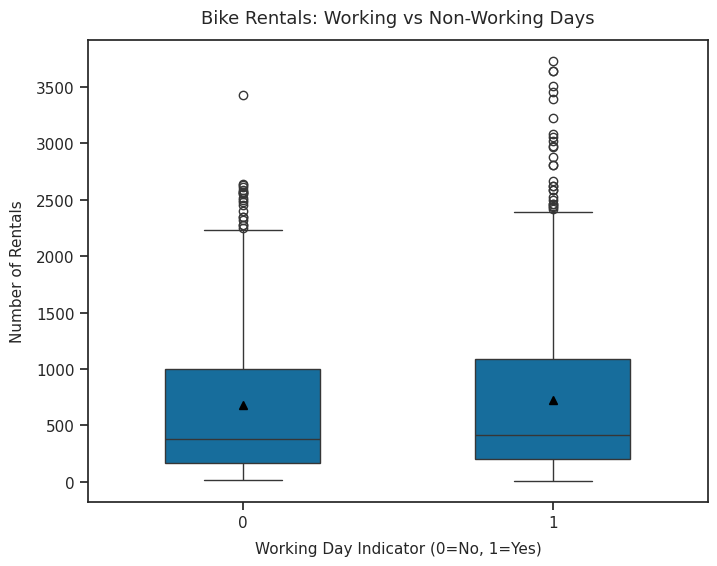

is_working_day
0    676.119122
1    725.078873
Name: rentals, dtype: float64


In [58]:
# Understanding if there is a difference
sns.boxplot(x = 'is_working_day',
            y = 'rentals',
            data = bikerentals,
            showmeans=True,
            meanprops=mp,
            width=0.5 # narrower with oh the histogram
            )

plt.title("Bike Rentals: Working vs Non-Working Days")
plt.xlabel("Working Day Indicator (0=No, 1=Yes)")
plt.ylabel("Number of Rentals")

plt.show()

#show the exact value of the means
print(bikerentals.groupby("is_working_day")["rentals"].mean())

We definetly see a very slight difference of about XYZ in the means for both groups. This points out that the bikes are used more during working days - which is an indicator that bikes could be using for communiting. Another proxy is the times where the bikes are used.

Peak hour definition: https://teamjustice.com/chicago-rush-hour-traffic/.

For a given working day:

In [55]:
# Defining a new boolean variable to identify rentals within peak hours
bikerentals["is_peak_hour"] = (
    bikerentals["hour"].isin([7, 8, 9, 16, 17, 18,19])
).astype(int)

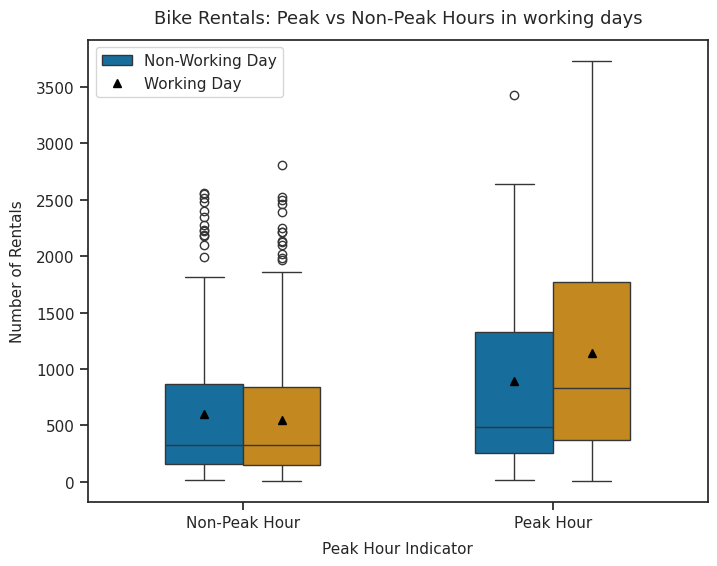

In [67]:
# Understanding if there is a difference between peak and non-peak hours
sns.boxplot(x = 'is_peak_hour',
            y = 'rentals',
            hue = "is_working_day",
            data = bikerentals,
            showmeans=True,
            meanprops=mp,
            width=0.5 # narrower width of the histogram
            )

plt.xticks([0, 1], ["Non-Peak Hour", "Peak Hour"])
plt.legend(["Non-Working Day", "Working Day"])


plt.title("Bike Rentals: Peak vs Non-Peak Hours in working days")
plt.xlabel("Peak Hour Indicator")
plt.ylabel("Number of Rentals")

plt.show()


In [57]:
hourly_demand = (
    bikerentals_complete
    .groupby("hour")["rentals"]
    .mean()
)

plt.figure(figsize=(10,6))
plt.plot(hourly_demand.index, hourly_demand.values, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.title("Average Bike Rentals by Hour of Day")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

NameError: name 'bikerentals_complete' is not defined

To do for question 1:
- Time series for hour of the day ( to confirm peak hours)
- Showing hours on weekends? Maybe to also say for leasure
- Showing differences in weekends and holidays based on weather vs differences in working days when weather is shit so we say that under the assumption that people communit are less elastic then we can confirm that

REVIEW DATA TYPE FOR HOLIDAY

# Question 2

## Dealing with categorical variables

### ONE HOT ENCODE

In [ ]:
# one hot encoding categorical variables
one_hot_month = pd.get_dummies(data   = bikerentals['month'],
                          prefix = 'month',
                          dtype  = int)

one_hot_month.value_counts()

In [ ]:
# one hot encoding categorical variables
one_hot_dow = pd.get_dummies(data   = bikerentals['day_of_week'],
                          prefix = 'dow',
                          dtype  = int)

one_hot_dow.value_counts()

In [ ]:
# one hot encoding categorical variables
one_hot_seasons = pd.get_dummies(data   = bikerentals['seasons'],
                          prefix = 'seasons',
                          dtype  = int)

one_hot_seasons.value_counts()

In [ ]:
bikerentals2 = bikerentals.join([one_hot_month, one_hot_dow, one_hot_seasons])
bikerentals2.head(n=5)

In [ ]:
# renaming channels and storing as diamonds (not diamonds2)
bikerentals2.rename(columns = {'dow_Monday': 'monday',
                            'dow_Tuesday': 'tuesday',
                            'dow_Wednesday': 'wednesday',
                            'dow_Thursday': 'thursday',
                            'dow_Friday': 'friday',
                            'dow_Saturday': 'saturday',
                            'dow_Sunday': 'sunday',
                            'month_Jan': 'jan',
                            'month_Feb': 'feb',
                            'month_Mar': 'mar',
                            'month_Apr': 'apr',
                            'month_May': 'may',
                            'month_June': 'jun',
                            'seasons_Spring': 'spring',
                            'seasons_Summer':'summer',
                            'seasons_Fall': 'fall',
                            'seasons_Winter': 'winter'
                            },
                inplace = True)


# checking results
bikerentals2.head(n = 5)

In [ ]:
bikerentals_complete = bikerentals2.drop(['monday',   # category to drop
                           'jan',  # already factorized
                           'spring',    # not enough samples per store
                            'day_of_week',
                            'month',
                            'seasons'
                          ], axis = 1)

In [ ]:
#sorting the dataset for better readability
new_order = [
    "rentals",                  # y-variable
    "hour",
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall",
    "holiday",
    "is_working_day",
    "is_peak_hour",
    "feb",                    #month dummies (Jan is baseline)
    "mar",
    "apr",
    "may",
    "jun",
    "tuesday",                #days dummies (Monday is baseline)
    "wednesday",
    "thursday",
    "friday",
    "saturday",
    "sunday",
    "summer",                #season dummies (Spring is baseline)
    "winter"
]

bikerentals_complete = bikerentals_complete[new_order]

bikerentals_complete.head()


In [ ]:
bikerentals_complete.info()

YES TO SEASONS

In [ ]:
corr_matrix = bikerentals_complete.corr(numeric_only=True)

plt.figure(figsize=(25, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
bikerentals_complete["peak_work_interaction"] = (
    bikerentals_complete["is_peak_hour"] *
    bikerentals_complete["is_working_day"]
)
#ADD RESEARCH

In [ ]:
bikerentals_complete["is_morning"] = bikerentals_complete["hour"].between(0, 10).astype(int)
bikerentals_complete["is_afternoon"] = bikerentals_complete["hour"].between(11, 16).astype(int)
bikerentals_complete["is_evening"] = bikerentals_complete["hour"].between(17, 23).astype(int)

In [ ]:
bikerentals_complete = bikerentals_complete.drop(['is_morning'
                          ], axis = 1)

In [ ]:
bikerentals_complete["is_midweek"] = (
    (bikerentals_complete["tuesday"] == 1) |
    (bikerentals_complete["wednesday"] == 1)
).astype(int)

In [ ]:
## x-side ##
x_all  = bikerentals_complete.drop(labels = 'rentals', axis = 1)
x_base = bikerentals_complete[ ['dew_point_temperature', "is_afternoon", "is_evening", 'humidity','uv_index','rainfall','snowfall',"peak_work_interaction",'is_working_day','is_peak_hour',\
                              'summer','winter' ]]

## y-side ##
y_original = bikerentals_complete['rentals']

In [ ]:
# x-data
x_data = x_base

# y_data
y_data = y_original

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

In [ ]:
# checking results
print(f"""
Data Shapes
-----------
x_train: {x_train.shape}
y_train: {y_train.shape}

x_test:  {x_test.shape}
y_test:  {y_test.shape}
""")

In [ ]:
# naming the model
model_name = "Linear Regression"


# INSTANTIATING model object
model = sklearn.linear_model.LinearRegression()


# FITTING to training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING results (R-Square)
model_train_score = round(model.score(x_train, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

In [ ]:
# Step 1: INSTANTIATE a model object
lm = smf.ols(formula =  """
        rentals ~
        dew_point_temperature +
        is_afternoon +
        is_evening +
        humidity +
        uv_index +
        rainfall +
        snowfall +
        peak_work_interaction+
        is_working_day +
        is_peak_hour +
        summer + winter
    """,
            data = bikerentals_complete)


# Step 2: FIT the data into the model object
results = lm.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

In [ ]:
## Residual Analysis ##

# organizing residuals
model_residuals = {
    "True"            : y_test,
    "Predicted"       : model_pred.round(decimals = 0).astype(dtype = int)
}


# converting residuals into df
resid_df = pd.DataFrame(data = model_residuals)


# checking results
resid_df.head(n = 5)

In [ ]:
# developing a residual plot
sns.residplot(data        = resid_df,
              x           = 'True',
              y           = 'Predicted',
              lowess      = True,
              color       = 'blue',
              scatter_kws = {'alpha': 0.3},   # data point transparency
              line_kws    = {'color': 'red'}) # line color


# title and axis labels
plt.title(label   = "Residual Plot - Full Model")
plt.xlabel(xlabel = "Predicted Bike Demand")
plt.ylabel(ylabel = "Residual Bike Demand")


# layout and rendering visual
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
pred_df = pd.DataFrame({
    "actual_rentals": y_test.values,
    "predicted_rentals": y_pred
})
pred_df[pred_df["predicted_rentals"] < 0]

### Other important findings:

**Midweek patterns (Tuesday and Wednesday)**

Exploratory analysis shows lower average rental demand on Tuesdays and Wednesdays. However, once weather conditions, time-of-day effects, and commuting structure are controlled for, this midweek effect is no longer statistically significant, suggesting it is driven by underlying temporal and commuting patterns rather than the calendar day itself.

# APPENDIX

## Categorical variables
Understanding how categorical variables behave

### Month
- Data available from January to June
- Over 30 obersvations in each month
- Definetly differences in rental medians and means across months:
  -  January and February are the months with les rentals
  - June is the month with most rentals
  - We ca see seasonality, meaning that months with generally better weather are months with more demand for rentals


In [ ]:
bikerentals["month"].value_counts()

In [ ]:
sns.boxplot(x = 'month',
            y = 'rentals',
            data = bikerentals,
            showmeans=True,
            meanprops=mp)

plt.show()

### Day of week
- Over 30 observations for each day of the week
- Differences in rental medians and means across days of week:
  - Tuesday and Wednesdays as the days with less rentals
  - Other days have closer means, with Monday being the day with higher usage

In [ ]:
bikerentals["day_of_week"].value_counts()

In [ ]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'day_of_week',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

    plt.suptitle("")
    plt.show()

In [ ]:
bikerentals.groupby("day_of_week")["rentals"].mean().sort_values()

### Season
- More observations for spring but still over 30 observations for each season
- Seasonal patterns confirmed with seasons:
  - Summer has the highest demand for rental bikes
  - Winter has the lower demand

In [ ]:
bikerentals["seasons"].value_counts()

In [ ]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'seasons',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

    plt.suptitle("")
    plt.show()